# TO for the Actuated Spring-Loaded Inverted Pendulum (ASLIP)

In [21]:
import numpy as np 

import matplotlib.pyplot as plt
#mport mpld3
from IPython.display import display
from IPython.display import Math, Latex

from pydrake.all import (MultibodyPlant, Parser, DiagramBuilder, Simulator, Box, ne,
                         PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource,
                         IpoptSolver, IpoptSolverDetails, MultibodyPositionToGeometryPose, PiecewisePolynomial,
                         MathematicalProgram,JacobianWrtVariable, eq, LinearQuadraticRegulator,
                         Linearize, AddMultibodyPlantSceneGraph, VectorSystem, le, ge, OsqpSolver, PrismaticJoint,
                         Cylinder,Box,RigidTransform, CoulombFriction, IllustrationProperties)

from pydrake.examples.compass_gait import CompassGait, CompassGaitGeometry
from pydrake.examples.rimless_wheel import (RimlessWheel, RimlessWheelGeometry,
                                            RimlessWheelParams)

from underactuated import running_as_notebook
from underactuated.jupyter import AdvanceToAndVisualize


# SLIP Dynamics Model

In [43]:
class SLIP_Model():
    def __init__(self):
        
        #SLIP model paramters 

        self.k = 5000 #spring constant 
        self.l_rest = 1 #undeformed leg length
        self.m = 80 #point mass 

        self.g = 9.81

        self.min_leg_torq = -50

        self.max_leg_torq = 50

        self.collocation_nodes_per_contact = 50

        # self.q = np.empty((1,4)) #state vector x,z,l,theta
        # self.qd = np.empty((1,4))
        # self.qdd = np.empty((1,4))

    def manipulator_equations_ground(self, vars):
        """
        Checks if the given state [pos, vel, accel, forcing (inputs) are dynamically feasible]
        Inputs: State
        Outputs: Manipulator Equation Sum (must be zero)
        """
        
        ## Stance Mode Manipulator Equations ##
        #states are in order of x,z,l,theta 
        #x_d, z_d, l_d, theta_d
        # x_dd, z_dd, l_dd, theta_dd
        q = vars[0:4]
        qdot = vars[4:8]
        qddot = vars[8:12]
        u=vars[12]

        l = q[2]
        l_d = qdot[2]
        l_dd = qddot[2]

        theta = q[3]
        theta_d = qdot[3]
        theta_dd = qddot[3]

        g = self.g
        m = self.m 
        s1 = np.sin(theta)
        c1 = np.cos(theta)
        k = self.k 
        l0 = self.l_rest 

        a = m*(-g*s1 + l*theta_dd + 2*l_d*theta_d)*l - u
        b = g*m*c1 - k*(l0 - l) - m*l*theta_d**2 + m*l_dd 
        
        return [a,b]

    def manipulator_equations_air(self,qddot):
        """
        Checks if the given swing/flight states are dynamically feasible
        We assume pure ballistic motion during flight, and the leg angle can be instantaneously controlled
        to any angle (leg angle does not show up in the equations of motion)

        Inputs: state variables
        Outputs: Checks if z_double_dot == 0 -g and x_double_dot ==0
        """

        x_dd = qddot[0]
        z_dd = qddot[1]

        equal_zeros = np.array([[x_dd],
                                [z_dd + self.g]])
        
        return [x_dd,z_dd + self.g]

    def get_foot_z_position(self, q):
        """
        foot position is not a state variable, but derived from center of mass
        position and leg configuration 

        useful for checking if the foot is in contact with ground for stance phase constraint
        """

        leg_height = q[2]*np.cos(q[3])
        
        return q[1] - leg_height

    def relate_pelvis_accel_to_leg_accel(self,q,qd,qdd):
        #x,z,l,theta
        ## find accelerations of the pelvis during stance using double derivates of the
        ## kinematic relationship bt x,z and l,theta 
        l1 = q[2]
        theta = q[3]
        l1_dot = qd[2]
        theta_dot = qd[3]
        l1_double_dot = qdd[2]
        theta_double_dot = qdd[3]
        x_double_dot = l1*np.sin(theta)*theta_dot**2 \
                        -l1*np.cos(theta)*theta_double_dot \
                        -np.sin(theta)*l1_double_dot \
                        -2*np.cos(theta)*l1_dot*theta_dot
        
        z_double_dot = l1*np.sin(theta)*theta_double_dot + \
                        l1*np.cos(theta)*theta_dot**2 + \
                        2*np.sin(theta)*l1_dot*theta_dot- \
                        np.cos(theta)*l1_double_dot

        return x_double_dot, z_double_dot
    def create_contact_schedule(self,trajectory_length):
        """
        Given a trajectory length in # of collocation points, find the
        contact schedule as a binary vector of length trajectory length
        
        0 => flight phase
        1 => stance phase

        This is only done once before the optimization 

        ASSUMED: 
        
            The SLIP model begins a trajectory in the beginning
            of a flight phase

            There are 50 collocation points per contact mode

        Input: trajectory length in collocation points

        Output: contact schedule vector 
        """

        if(trajectory_length % self.collocation_nodes_per_contact != 0):
            raise Exception("trajectory length is not divisible by collocation nodes per contact phase")

        contact_schedule = np.zeros(trajectory_length)

        cnpc = self.collocation_nodes_per_contact
        for idx in range(trajectory_length):

            start, end = (idx*cnpc,idx*cnpc+50)
            #if idx is even, then we are in flight phase
            if idx % 2 == 0:
                contact_schedule[start:end] = 0
            else:
                contact_schedule[start:end] = 1

        return contact_schedule



# Mathematical Program

True
[]
[0.08755711]
[0.01549954]


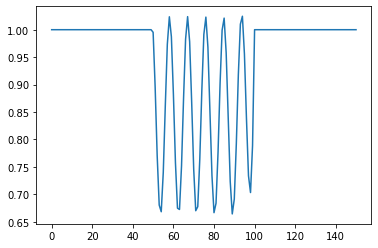

In [47]:
prog=MathematicalProgram()

#create SLIP instance
slip_model = SLIP_Model()


#50 collocation points per contact phase, starts in beginning of flight
number_of_collocation_points = 150

minimum_clearance_height = 0.5 # every jump apex must be above this height

initial_height = 4
goal_displacement = 0
#slip model initial and final states
#[x,z,l,theta]
#
q_initial_state = np.array([0,4,slip_model.l_rest,0])
q_dot_initial_state = np.array([0,0,0,np.pi/4])

q_final_state = np.array([goal_displacement,4,slip_model.l_rest,0])
q_dot_final_state = np.array([0,0,0,0])

#constraints for max/min timestep lengths in swing and stance

h_max_swing=.1
h_min_swing=.001

h_max_stance=.1
h_min_stance=.001

## set up decision variables ##

#decide time step lengths for swing and stance
h_swing = prog.NewContinuousVariables(1,"h_swing")
h_stance = prog.NewContinuousVariables(1,"h_stance")

#decide state positions 
q=prog.NewContinuousVariables(number_of_collocation_points+1,4,'q')
#decide state velocities
qd=prog.NewContinuousVariables(number_of_collocation_points+1,4,'qd')
#decide state accelerations
qdd=prog.NewContinuousVariables(number_of_collocation_points,4,'qdd')
#decide leg input torques
u=prog.NewContinuousVariables(number_of_collocation_points,1,'u') 



ground_schedule = slip_model.create_contact_schedule(number_of_collocation_points)
#print(ground_schedule)

## set up constraints ## 

#initial state constraints
    #position
prog.AddLinearConstraint( q[0,0] == q_initial_state[0]).evaluator().set_description('x_init') #x position
prog.AddLinearConstraint( q[0,1] == q_initial_state[1]).evaluator().set_description('z_init') #z position
prog.AddLinearConstraint( q[0,2] == q_initial_state[2]).evaluator().set_description('l_init') #l length

    #velocity
prog.AddLinearConstraint( qd[0,0] == q_dot_initial_state[0] ).evaluator().set_description('xd_init')  #x vel
prog.AddLinearConstraint( qd[0,1] == q_dot_initial_state[1] ).evaluator().set_description('zd_init')  #z vel
#prog.AddLinearConstraint( qd[0,2] == q_dot_initial_state[2] ) #l vel
prog.AddLinearConstraint( qd[0,3] == q_dot_initial_state[3] ).evaluator().set_description('thetad_init')  #theta vel


#final state contraints
    #position
prog.AddLinearConstraint(q[number_of_collocation_points,0] == q_final_state[0] ).evaluator().set_description('x_final')
prog.AddLinearConstraint(q[number_of_collocation_points,1] <= q_final_state[1] ).evaluator().set_description('z_final') 
    #velocity
prog.AddLinearConstraint(qd[number_of_collocation_points,0] == q_dot_final_state[0] ).evaluator().set_description('xd_final')
prog.AddLinearConstraint(qd[number_of_collocation_points,1] >= q_dot_final_state[1] ).evaluator().set_description('zd_final') 

#Actuator torque bound constraint 
prog.AddBoundingBoxConstraint([slip_model.min_leg_torq]*number_of_collocation_points, 
                              [slip_model.max_leg_torq]*number_of_collocation_points,
                              u
                              ).evaluator().set_description('torq_bounds')

# time step constraints 
prog.AddBoundingBoxConstraint(h_min_swing,h_max_swing,h_swing).evaluator().set_description('swing time bound')
prog.AddBoundingBoxConstraint(h_min_stance,h_max_stance,h_stance).evaluator().set_description('stance time bound')

# Contact Sequence Dependent Dynamics Constraints 

for i in range(number_of_collocation_points):
    #if swing:
    if ground_schedule[i] == 0: #swing
        #swing dynamics constraints
        #air = slip_model.manipulator_equations_air(qdd[i,:])
        prog.AddConstraint(slip_model.manipulator_equations_air, lb = [0]*2,ub=[0]*2,vars=qdd[i,:])
        #euler integration constraint  
        prog.AddConstraint( eq( q[i+1], q[i] + h_swing * qd[i+1]  ))
        prog.AddConstraint( eq( qd[i+1], qd[i] + h_swing * qdd[i]  ))
        # #x,xdot
        # prog.AddConstraint( eq( q[i+1,0], q[i,0] + h_swing * qd[i+1,0]  ))
        # prog.AddConstraint( eq( qd[i+1,0], qd[i,0] + h_swing * qdd[i,0]  ))
        # # # #z,zdot
        # prog.AddConstraint( eq( q[i+1,1], qd[i,1] + h_swing * qd[i+1,1]  ))
        # prog.AddConstraint( eq( qd[i+1,1], qd[i,1] + h_swing * qdd[i,1]  ))

        #constrain the leg length to be rest length when in swing
        prog.AddLinearConstraint(q[i,2]==slip_model.l_rest)
        prog.AddCost(h_swing[0]*u[i].dot(u[i]))
        
    else:
        #stance dynamics constraints
        #ensure the foot is on the ground
        prog.AddConstraint(slip_model.get_foot_z_position(q[i,:])==0)

        var = np.concatenate((q[i,:],qd[i,:],qdd[i,:],u[i,:]))
        prog.AddConstraint(slip_model.manipulator_equations_ground, lb =[0]*2,ub=[0]*2,vars=var)
        
        #euler integration constraint 
        
        prog.AddConstraint( eq( q[i+1], q[i] + h_stance * qd[i+1]  ))
        prog.AddConstraint( eq( qd[i+1], qd[i] + h_stance * qdd[i]  ))

        #constraint relating x_dd, z_dd to l_dd, and theta_dd 

        #prog.AddConstraint(qdd[i,0] == slip_model.relate_pelvis_accel_to_leg_accel(q[i,:],qd[i,:],qdd[i,:])[0] )
        #prog.AddConstraint(qdd[i,1] == slip_model.relate_pelvis_accel_to_leg_accel(q[i,:],qd[i,:],qdd[i,:])[1] )
        #R = 5
        #prog.AddCost(h_swing[0]*u[i].dot(u[i]))

from pydrake.solvers.mathematicalprogram import Solve
result = Solve(prog)

print(result.is_success())
print(result.GetInfeasibleConstraints(prog))

pos = result.GetSolution(q)

#print(pos[:,3])
plt.plot(pos[:,1])
print(result.GetSolution(h_stance))
print(result.GetSolution(h_swing))

plt.show()

[0.08755711]
[0.01549954]


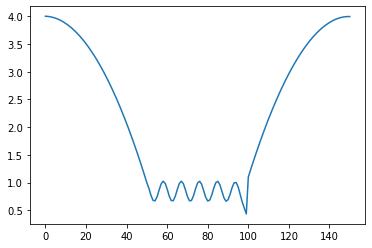

In [46]:
pos = result.GetSolution(q)

#print(pos[:,3])
plt.plot(pos[:,1])
print(result.GetSolution(h_stance))
print(result.GetSolution(h_swing))

plt.show()

Ground Equations of Motion 

In [ ]:
Math(r'\left[\begin{matrix}m \left(- g \sin{\left(\operatorname{t_{1}}{\left(t \right)} \right)} + \operatorname{L_{1}}{\left(t \right)} \frac{d^{2}}{d t^{2}} \operatorname{t_{1}}{\left(t \right)} + 2 \frac{d}{d t} \operatorname{L_{1}}{\left(t \right)} \frac{d}{d t} \operatorname{t_{1}}{\left(t \right)}\right) \operatorname{L_{1}}{\left(t \right)}\\g m \cos{\left(\operatorname{t_{1}}{\left(t \right)} \right)} - k \left(L_{1 0} - \operatorname{L_{1}}{\left(t \right)}\right) - m \operatorname{L_{1}}{\left(t \right)} \left(\frac{d}{d t} \operatorname{t_{1}}{\left(t \right)}\right)^{2} + m \frac{d^{2}}{d t^{2}} \operatorname{L_{1}}{\left(t \right)}\end{matrix}\right]')

<IPython.core.display.Math object>

In [ ]:

##################### I copied this code from online ############# 
#This program works to get the hopper to jump up steps at a steady rate

prog=MathematicalProgram()
N_step=150

step_length=0.5
step_height=0.5

y_i = 0.5 #initial height

q_initial=[0,y_i,0,0,0]
#qd_initial=[0,0,0,0,0]

q_final=[step_length,y_i+step_height,0,0,0]

h_max_air=.05
h_min_air=.001

h_max_g=.05
h_min_g=.001

#decision variables
h_air=prog.NewContinuousVariables(1,'h_air') #time step air
h_g=prog.NewContinuousVariables(1,'h_g') #time step ground

q=prog.NewContinuousVariables(N_step+1,4,'q')
qd=prog.NewContinuousVariables(N_step+1,4,'qd')
qdd=prog.NewContinuousVariables(N_step,4,'qdd')
u=prog.NewContinuousVariables(N_step,1,'u') 

#make grounded variable pre-scheduled 
number_of_contacts=1
grounded_step=get_ground_schedule(N_step,number_of_contacts)
M=100

#sets initial values for x, y, thetas are allowed to move freely
prog.AddLinearConstraint(q[0,0]==q_initial[0])
prog.AddLinearConstraint(q[0,1]==q_initial[1])

#ensures final values are same as initial values for position and velocty, with final x and y shifted by step_height and step_width
prog.AddLinearConstraint(q[N_step,0]==q_final[0])
prog.AddLinearConstraint(q[N_step,1]==q_final[1])
prog.AddLinearConstraint(q[N_step,4]==q_final[4])
prog.AddLinearConstraint(q[N_step,2]==q[0,2])
prog.AddLinearConstraint(q[N_step,3]==q[0,3])
prog.AddLinearConstraint(eq(qd[N_step],qd[0])) 

prog.AddLinearConstraint(qd[0,1]>=0) #helps push solver in correct direction to get it to solve

#actuator constraints
prog.AddBoundingBoxConstraint([0]*N_step,[0.8]*N_step,uZ)
prog.AddBoundingBoxConstraint([-10]*N_step,[10]*N_step,uT)

#time step constraints
prog.AddBoundingBoxConstraint(h_min_air,h_max_air,h_air)
prog.AddBoundingBoxConstraint(h_min_air,h_max_air,h_air_2)
prog.AddBoundingBoxConstraint(h_min_g,h_max_g,h_g)

for t in range(N_step):
  prog.AddBoundingBoxConstraint(-1*np.ones(1),0.1*np.ones(1),q[t+1,4]) #fails with -0.8 as lower bound, even though it never reaches -0.8

  c=(q[t+1,4]+0.5)**2 >= 0.00001
  #print(c)
  prog.AddConstraint(c) #not equal to -0.5

  if grounded_step[t]: #grounded dynamics
    prog.AddLinearConstraint(q[t+1,1]<=0) #constrains toe to be on the ground during scheduled grounded times

    prog.AddConstraint(eq(q[t+1] , q[t] + h_g * qd[t+1]))
    prog.AddConstraint(eq(qd[t+1] , qd[t] + h_g * qdd[t]))

    var=np.concatenate((q[t+1],qd[t+1],qdd[t],uZ[t],uT[t]))
    prog.AddConstraint(manipulator_equations_ground, lb=[0]*nq, ub=[0]*nq, vars=var) #dynamics constraint

    prog.AddCost(h_g[0]*uT[t].dot(uT[t]))
    prog.AddCost(h_g[0]*uZ[t].dot(uZ[t]))

  else: #air dynamics
    prog.AddLinearConstraint(q[t+1,1]>=0) #toe is above ground while in the air
    if t>N_step/2: #selects which time step to use
      #print("ooh")
      h=h_air_2
    else:
      h=h_air
    prog.AddLinearConstraint(eq(uZ[t],0)) #if in air, no spring pre loading. Helps solver find solutions too
    prog.AddConstraint(eq(q[t+1] , q[t] + h * qd[t+1]))
    prog.AddConstraint(eq(qd[t+1] , qd[t] + h * qdd[t]))
    
    var=np.concatenate((q[t+1],qd[t+1],qdd[t],uZ[t],uT[t],))
    prog.AddConstraint(manipulator_equations_air, lb=[0]*nq, ub=[0]*nq, vars=var) #dynamics constraint
    
    prog.AddCost(h[0]*uT[t].dot(uT[t]))
    #prog.AddCost(h[0]*uZ[t].dot(uZ[t])) #not needed because uZ[t] is 0


solver=SnoptSolver()
result=solver.Solve(prog)

print(result.is_success())

q_star_step=result.GetSolution(q)
qd_star_step=result.GetSolution(qd)
qdd_star_step=result.GetSolution(qdd)
h1_step=result.GetSolution(h_air)
h2_step=result.GetSolution(h_g)
h3_step=result.GetSolution(h_air_2)
print(h1_step,h2_step,h3_step)
steps=np.linspace(0,N_step,N_step+1)
uZ_star_step=result.GetSolution(uZ)
uT_star_step=result.GetSolution(uT)
print(GetInfeasibleConstraints(prog,result))

plt.figure()
plt.plot(steps[1:],grounded_step)
plt.plot(steps,q_star_step[:,4])

plt.figure()
plt.plot(steps[1:],uZ_star_step)

plt.figure()
plt.plot(q_star_step[:,0],q_star_step[:,1])